# Neural networks tutorial

## Introduction


**Neural networks** are the amongst the most powerful and adaptable of the machine learning algorithms. Inspired by biology, they are formed by layers of connected **nodes**, with each connection being a **weight**. At each node, the weighted sum of the values of all of the nodes connected to it is passed through a non-linear **activation function**, and the output of this function then defines the value at that node. A single node with a set of inputs and weights and one output is known as a **perceptron** and when perceptrons are arranged into layers, with the nodes in each layer being connected to every node in the next layer, this is called a **fully connected multi-layer peceptron** (MLP). Layers of nodes between the input and output are known as **hidden layers**; an MLP with several or many hidden layers is referred to as **deep** and this leads to the concept of **deep learning**.

In common with many ML algorithms, training involves adjusting the weights using gradient descent to minimize an objective function. To give the minimizer a set of gradients which it can use for the weight adjstment, a process called **back-propagation** calculates the gradients of the objective function with respect to each weight. Neural network training proceeds as follows:

 * Weights are initially randomized
 * Pass each event through the network (feed forward) arriving at a result
 * Compare with the target using some loss function, arriving at some error
 * Propagate this error backwards through the network, node by node and layer by layer, until each node has its own contribution to the overall error
 * Use these errors to calculate the partial derivatives of the loss function w.r.t. the weight at each neuron (gradients), by recursively applying the chain rule for derivatives
 * Use gradient descent to minimise the loss, which it does by updating the weights
 * New examples are then passed through the trained network with the weights fixed. 

Note that back-propagation is not the entire training procedure for a neural network - it sets up the gradient through calculation of the derivatives but the training is completed by the minimisation of this function via weight adjustment.

An **epoch** is a single pass through all of the training data. Training over 100 epochs means the networks sees the training data, in full, 100 times. In **stochastic training** each new event leads to a weight update; this is noisier so less likely to fall into local minima during minimization. In **batch training** weights are only updated after a large number of events have been fed forwards, with the errors accumulating; this is faster but uses more memory. **Mini-batch** training is a compromise between the two, with small batches being selected at random from the full sample.

Neural networks have a huge variety of hyperparameters. Aside from the size and shape of the network (number of hidden layers and the number of nodes in the different layers) there are also a wide range of regularisation techniques to avoid over-training (including **weight decay**, **dropout**, **momentum** and **early stopping**). There are also many choices that can be made in terms of the activation function in each layer. Taken together, this variety make neural networks hugely powerful and flexible but also challenging to optimally apply to a problem.    

MLPs require the input data to be rectagular, that is, each event must have the same number of variables and each variable must be defined. For data that doesn't conform to this, there are several architectual variations, designed for specific types of data, that shape the data into a form that can be ingested by an MLP. These include **comvolutional networks** for images, **recurrent networks** for time sequences and **graph networks** for data organised as connected graphs. Each of these types requires significant additional expertise to get the best performance.

For more information on neural networks, please refer to the slides delivered as part of FYS5555. For an in-depth review of the topic, the (free) online [Deep Learning Book](https://www.deeplearningbook.org) is an excellent and thorough guide.



## Getting started

In this tutorial you will build a neural network and apply it to the same dataset as was used in the BDT tutorial - the Higgs ML Challenge dataset. It will follow closely the structure of the BDT tutorial and assumes that you have completed this earlier part.

If you are using the Oslo Galaxy service there is no need to install any software. If you are using your own computer, you should follow the installation instructions in the README of this package. 

Throughout we will use [Keras](https://keras.io) - a package for building neural network models, which is implemented in Google's TensorFlow framework

We will use data internally generated by SciKitLearn as well as data from the [Open Data Portal](http://opendata.cern.ch)

Before starting anything else, you check that everything is working correctly by running the cell immediately below...

In [1]:
# Import of required packages
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization
import matplotlib.pyplot as plt
import matplotlib
# Preliminaries ensuring the plots aren't too small
matplotlib.rcParams.update({'font.size': 20})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

2023-04-18 21:24:44.250736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Using the HiggsML dataset

In this section we will apply a neural network to a "real" dataset from the OpenData Portal - the [HiggsML dataset](http://opendata.cern.ch/record/328). This is simulated data that was used for the HiggsML Challenge some years ago (and in fact, XGBoost won the challenge). The dataset is in plain text format and consists of columns of physics quantities plus a label indicating whether the event (row) is signal or background. The signal is the challenging H$\to\tau\tau$ decay. 

We will first use Pandas to extract the information from the plain text file, and then apply XGBoost to it. We will study some of the BDT properties along the way.

First take a look at the documentation accompanying the HiggsML challenge. In particular pay particular attention to the list of variables. Note two things in particular:
* Apart from the columns defining event weights and other supplementary information, the variable names begin either with "PRI" or "DER". This stands for "primary" (variables directly representing a reconstructed object like a track or jet) and "derived" (variables calculated from reconstructed objects, that impose additional knowledge of physics
* Some of the variables can only be defined when certain reconstructed objects exist: for instance, if there are no jets then `PRI_jet_leading_pt` cannot be defined since there is no leading jet. In the HiggsML dataset such entries are set to `-999.9` to indicate that the variable doesn't exist for this event. Such undefined variables are very troublesome for many machine learning algorithms and must be preprocessed away beforehand - but they present no problem for BDTs. All you have to do is tell the algorithm that any value with `-999.0` should be ignored, and if it needs to cut on these variables, it just assigns the events where the variable is missing to one leaf or the other, according to some criteria.

### Using Pandas to extract the data

**Try it out**: download the comma-separated-values data file from the above link, extract (uncompress) it and place it in the same directory as this notebook (some operating systems, e.g. macOS, may do the extraction automatically on download). Then, import the data with the columnnar-data handling package [Pandas](https://pandas.pydata.org), which ships with Anaconda. Plot some (maybe all) of the different values. Then create the data samples.

In [2]:
# Import the Pandas package
import pandas as pd
# Import the HiggsML dataset
df = pd.read_csv("/storage/shared/data/fys5555/higgsch/atlas-higgs-challenge-2014-v2.csv") #,usecols=variables)
#df = pd.read_csv("/Users/jamesrc/cernbox/FYS5555/atlas-higgs-challenge-2014-v2.csv")
# Take a look at the first five rows (events) of the resulting Pandas dataframe
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [3]:
# Turn the signal and background labels into 0s and 1s
df.Label = df.Label.replace('s',1) 
df.Label = df.Label.replace('b',0) 
df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,1,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,0,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,0,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,0,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,0,t,6.245333


In [4]:
# Get the full list of variable names
print(df.dtypes)

EventId                          int64
DER_mass_MMC                   float64
DER_mass_transverse_met_lep    float64
DER_mass_vis                   float64
DER_pt_h                       float64
DER_deltaeta_jet_jet           float64
DER_mass_jet_jet               float64
DER_prodeta_jet_jet            float64
DER_deltar_tau_lep             float64
DER_pt_tot                     float64
DER_sum_pt                     float64
DER_pt_ratio_lep_tau           float64
DER_met_phi_centrality         float64
DER_lep_eta_centrality         float64
PRI_tau_pt                     float64
PRI_tau_eta                    float64
PRI_tau_phi                    float64
PRI_lep_pt                     float64
PRI_lep_eta                    float64
PRI_lep_phi                    float64
PRI_met                        float64
PRI_met_phi                    float64
PRI_met_sumet                  float64
PRI_jet_num                      int64
PRI_jet_leading_pt             float64
PRI_jet_leading_eta      

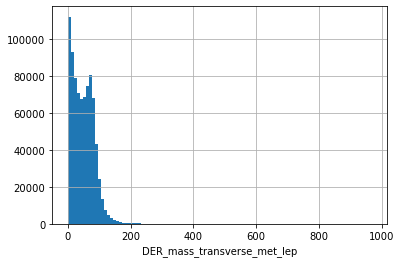

In [5]:
# Inspect some (or all...) of the columns using the names printed in the above cell
variable = 'DER_mass_transverse_met_lep' 
hist = df[variable].hist(bins=100)
hist.set_xlabel('DER_mass_transverse_met_lep')
plt.show()

In [6]:
# Split the data into training, validation and evaluation sets
# Note that the validation set here isn't used for hyperparameter tuning but for monitoring accuracy
drop = ["Weight","KaggleSet","KaggleWeight","EventId"] # Remove features that shouldn't be used in training
eval_dataframe = df.drop(drop,axis=1).sample(frac=0.8, random_state=1337)
trainval_dataframe = df.drop(drop,axis=1).drop(eval_dataframe.index)
val_dataframe = trainval_dataframe.sample(frac=0.2, random_state=1245)
train_dataframe = trainval_dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation; %d available for evaluation"
    % (len(train_dataframe), len(val_dataframe), len(eval_dataframe))
)


Using 130918 samples for training and 32730 for validation; 654590 available for evaluation


In [7]:
# Prepare keras datasets
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("Label") # This tells the model what the targets are
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    #ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe).batch(32)
val_ds = dataframe_to_dataset(val_dataframe).batch(32)

2023-04-18 21:25:06.217115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Normalizing the data

Unlike BDTs, but in common with most ML algorithms, neural networks must be passed **normalized** data. This can be easily done using a Keras tools as shown in the cell below. Note that the scaling transformation derived from the training data must also be applied to the test and evaluation data as well, since to do otherwise would run the risk of imposing skews which could lead to unpredicatable results.


In [8]:
# Function for normalising numerical features
def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature

### Building the neural network model

We're now ready to start constructing the neural network. First we build up the features one at a time, applying the normalization as we proceed. 

In [9]:
numerical_features = {}
numerical_features_encoded = {}
for name in df.drop(drop+["Label"], axis=1).columns:
    numerical_features[name] = keras.Input(shape=(1,), name=name)
    numerical_features_encoded[name] = encode_numerical_feature(numerical_features[name], name, train_ds)
all_inputs = list(numerical_features.values())
all_features = layers.concatenate(list(numerical_features_encoded.values()))

Now we can build the neural network itself. Here we have a single hidden layer with 30 nodes (one per input) and rectified linear activation. The output layer is a single sigmoid node.

In [11]:
# Build the neural network. 
x = layers.Dense(30, activation="relu")(all_features)
x = layers.Dropout(0.5)(x) # This is a regularisation setting
output = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"]) 
# Hyperparemetrs: "adam" - gradient descent algorithm; "binary_crossentropy" - loss function measure

In [12]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Now we're ready to run the training...

In [13]:
# Run training, 50 passes over the training dataset
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
4092/4092 [==============================] - 8s 2ms/step - loss: 0.4910 - accuracy: 0.7618 - val_loss: 0.4264 - val_accuracy: 0.8075
Epoch 2/50
4092/4092 [==============================] - 7s 2ms/step - loss: 0.4487 - accuracy: 0.7945 - val_loss: 0.4184 - val_accuracy: 0.8119
Epoch 3/50
4092/4092 [==============================] - 7s 2ms/step - loss: 0.4430 - accuracy: 0.7990 - val_loss: 0.4151 - val_accuracy: 0.8140
Epoch 4/50
4092/4092 [==============================] - 7s 2ms/step - loss: 0.4402 - accuracy: 0.7997 - val_loss: 0.4108 - val_accuracy: 0.8159
Epoch 5/50
4092/4092 [==============================] - 7s 2ms/step - loss: 0.4390 - accuracy: 0.8016 - val_loss: 0.4109 - val_accuracy: 0.8167
Epoch 6/50
4092/4092 [==============================] - 7s 2ms/step - loss: 0.4377 - accuracy: 0.8031 - val_loss: 0.4072 - val_accuracy: 0.8177
Epoch 7/50
4092/4092 [==============================] - 7s 2ms/step - loss: 0.4374 - accuracy: 0.8038 - val_loss: 0.4071 - val_accuracy:

### Interfence

The model is now trained and the weights are fixed. Probably you'll be getting a reported validation accuracy of just over 80%. We can now pass events through the the network in "feed forward" mode, getting an output for each event. The closer to one the output is, the closer to being signal-like the event is. 

In [17]:
# Test the NN performance using the validation dataset
nn_output = model.predict( val_ds ) 

1023/1023 [==============================] - 1s 1ms/step


Now we are in a position to plot the NN outputs on the validation dataset for signal and background, and the resulting response-operator (ROC) curves, using the BDT outputs obtained in the cell above. The more separated the background and signal distributions, the better the model is performing.

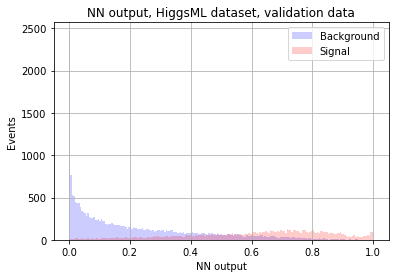

In [26]:
#  histogram of the BDT outputs
n, bins, patches = plt.hist(nn_output[:,0][val_dataframe.Label==0], 200, facecolor='blue', alpha=0.2,label="Background")
n, bins, patches = plt.hist(nn_output[:,0][val_dataframe.Label==1], 200, facecolor='red', alpha=0.2, label="Signal")

plt.xlabel('NN output')
plt.ylabel('Events')
plt.title('NN output, HiggsML dataset, validation data')
plt.grid(True)
plt.legend()
plt.show()

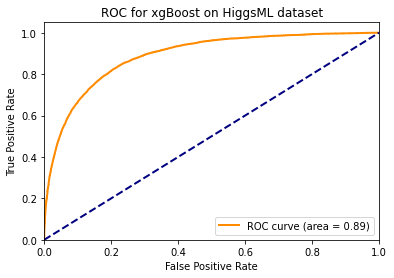

In [25]:
# ROC curve
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(val_dataframe.Label,nn_output[:,0], pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for xgBoost on HiggsML dataset')
plt.legend(loc="lower right")
plt.show()

**Try it out**: re-run the NN a few times with different numbers of hidden layers, different activations, regularisation strategies etc. You can also try to increase the number of events used in the training by adjusting the fraction of events going into the (unused) evaluation dataset. You can find more information on the available parameters in the [Keras documentation](https://keras.io). Inspect the outputs and the resulting ROC. 

### Neural network hyperparameter tuning

Keras offers a [hyperparameter tuning facility](https://keras.io/keras_tuner/) somewhat similar to the XGBoost version. Its use is beyond the scope of this tutorial, but you are welcome to try it out by following the instructions on the website. The procedure is the same as for the BDT: sets of parameters are selected at random and cross validation is performed by shuffling the training and validation data in each cycle. The final performance is then tested using the evaluation sample, which you'll note we have not used. 

## Comparing BDTs and neural networks

Now that you've had a chance to try both BDTs and neural networks, you may have appreciated some important differences:

 * There is no simple way to measure variable importance with a neural network, unlike with a BDT
 * Variables with little discriminating power can adversely affect the performance of a neural network, whereas BDTs are unaffected
 * Data must be normalised before ingestion into a neural networks; this is unnecessary with BDTs
 * Variables that are undefined for some events (e.g. pT of the third jet in an event with fewer than three jets) are a serious problem in neural networks and must be filled with some value in some way, or the data must be recast to side-step the problem. BDTs are unaffected by such empty variables, as long as they are labelled as such in the input. Note that this isn't an issue in the HiggsML dataset as the data was curated to avoid such issues.
 
As a general rule, simple classification problems with limited statistics such as the HiggsML challenge are best addressed with a BDT since a shallow neural network is unlikely to outperform it and has the drawbacks listed above. However, problems involving very large datasets could benefit from the greater learning capacity of deep neural networks, which will start to outpeform a BDT at some level of statistics. More complex problems involving graph, image or sequence data need the flexibility offered by the wide variety of neural network architectures. 

In the end, the right tool should be used for the right job - reach for simpler tools where they are sufficient to address the problem, and for more powerful and complex tools when these are justified.


## Next steps

Now that you have a bit of experience with BDTs and neural networks, you might like to try to apply your knowledge to the ATLAS Open Data. See the README for the relevant links.